In [1]:
import numpy as np

import lab_utils

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

import PIL
from PIL import Image
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
import os
import sys

import torchvision.transforms as transforms
import torchvision.models as models

import csv

from tqdm import tqdm as tqdm

### Define Style Feature Extraction Network Based on VGG

In [2]:
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

cnn = models.vgg19(pretrained=True).features

# move it to the GPU if possible:
if use_cuda:
    cnn = cnn.cuda()
    
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

networks = []

for i in range(5):
    model = nn.Sequential()
    networks.append(model)

indexs = [1, 3, 6, 8, 11]

for n in range(5):
    count = 0
    for layer in list(cnn)[:indexs[n]]:
        networks[n].add_module(str(count), layer)
        count += 1


### Model Define

In [3]:
class MovieGenreClassifier(nn.Module):
    def __init__(self, nlabel):
        super(MovieGenreClassifier, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(64 * 64 + 64 * 64 + 128 * 128 + 128 * 128 + 256 * 256, 64),
            nn.ReLU(),
            nn.Linear(64, nlabel),
        )

    def forward(self, input):
        return self.main(input)

def extractStyleFeature(image, networks):
    features = []
    for network in networks:
        features.append(network(image))
    for i in range(len(features)):
        features[i] = gram(features[i]).view(1, -1)
    
    return torch.cat((features[0], features[1], features[2], features[3], features[4]), 1)
    
def extractLabel(image, id2genre, genresTable):
    genres = id2genre[image]
    genres = genres.split('|')
    labelVec = torch.zeros(1, 23)
    for genre in genres:
        if genre in genresTable:
            labelVec[0][genresTable[genre]] = 1
    
    return labelVec

### Define Gram Matrix to Calculate Style Feature

In [4]:
loader = transforms.Compose([
    transforms.Scale((182, 268)),
    transforms.ToTensor()])  # transform it into a torch tensor

def image_loader(image_name):
    image = Image.open(image_name)    
    image = Variable(loader(image))
    # fake batch dimension required to fit network's input dimensions
    image = image.unsqueeze(0)
    return image

class GramMatrix(nn.Module):
    def forward(self, input):
        a, b, c, d = input.size()  # a=batch size(=1)
        # b=number of feature maps
        # (c,d)=dimensions of a f. map (N=c*d)

        features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(a * b * c * d)

gram = GramMatrix()
if use_cuda:
    gram = gram.cuda()


### Define Custom Dataset

In [5]:
class MyDataset(Dataset):
    def __init__(self, root, csvfile, networks, transform=None):
        self.root = root
        self.transform = transform
        self.csvfile = open(csvfile, 'rb')
        self.networks = networks
        
        reader = csv.reader(self.csvfile)

        id2genre = {}

        for row in reader:
            if row[0] != "":
                id2genre[row[0] + ".jpg"] = row[4]
        
        self.csvfile = open(csvfile, 'rb')
        
        reader = csv.reader(self.csvfile)
        
        genres = {}
        for row in reader:
            genre = row[4].split('|')
            for ele in genre:
                if ele != '':
                    genres[ele] = genres.get(ele, 0) + 1

        for ele in list(genres):
            if (genres[ele] < 100):
                del genres[ele]        

        genresTable = {}

        count = 0
        for ele in list(genres):
            genresTable[ele] = count
            count += 1
                
        self.dataset = []
        self.labels = []
        
        count = 0
        for img in tqdm(os.listdir(self.root)):
            image = io.imread(os.path.join(self.root, img))
            count += 1

            self.dataset.append(image)
            self.labels.append(extractLabel(img, id2genre, genresTable))

    def __len__(self):
        return len(os.listdir(self.root))

    def __getitem__(self, idx):
        image = self.dataset[idx]
        label = self.labels[idx]
        
        image = Image.fromarray(image)
        
        if self.transform is not None:
            image = self.transform(image)

        image = Variable(loader(image))
        
        image = image.cuda()
        # fake batch dimension required to fit network's input dimensions
        image = image.unsqueeze(0)        
        
        feature = extractStyleFeature(image, self.networks)
        
        return feature.data, label
                               
trainset = MyDataset(root='/home/ubuntu/notebooks/dataset/train',
                     csvfile='/home/ubuntu/notebooks/Movie-Genre-Classification-from-Movie-Poster/Dataset/NewMovieGenre.csv', networks=networks)
valset = MyDataset(root='/home/ubuntu/notebooks/dataset/validation/',
                   csvfile='/home/ubuntu/notebooks/Movie-Genre-Classification-from-Movie-Poster/Dataset/NewMovieGenre.csv', networks=networks)

100%|██████████| 1891/1891 [00:02<00:00, 870.50it/s]


### Train the Model

In [6]:
trainLoader = torch.utils.data.DataLoader(trainset, batch_size = 128, 
                                          shuffle = True, num_workers = 0)

valLoader = torch.utils.data.DataLoader(valset, batch_size = 128,
                                        shuffle = True, num_workers = 0)

def train_model(network, criterion, optimizer, trainLoader, valLoader, n_epochs = 10, use_gpu = False):
    if use_gpu:
        network = network.cuda()
        criterion = criterion.cuda()
        
    # Training loop.
    for epoch in range(0, n_epochs):
        correct = 0.0
        cum_loss = 0.0
        counter = 0

        # Make a pass over the training data.
        t = tqdm(trainLoader, desc = 'Training epoch %d' % epoch)
        network.train()  # This is important to call before training!
        for (i, (inputs, labels)) in enumerate(t):
            
            # Wrap inputs, and targets into torch.autograd.Variable types.
            inputs = Variable(inputs)
            labels = Variable(labels)
            
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # Forward pass:
            outputs = network(inputs)
            loss = criterion(outputs, labels)

            # Backward pass:
            optimizer.zero_grad()
            # Loss is a variable, and calling backward on a Variable will
            # compute all the gradients that lead to that Variable taking on its
            # current value.
            loss.backward() 

            # Weight and bias updates.
            optimizer.step()
            
            # logging information.
            cum_loss += loss.data[0]
            
            outlabels = (outputs.data.exp() / (outputs.data.exp() + 1)).round()
            
            correct += ((labels.data * outlabels).sum(2).sum(1) / (labels.data + outlabels).clamp(0, 1).sum(2).sum(1)).sum()
            counter += inputs.size(0)
            t.set_postfix(loss = cum_loss / (1 + i), accuracy = 100 * correct / counter)

        # Make a pass over the validation data.
        correct = 0.0
        cum_loss = 0.0
        counter = 0
        t = tqdm(valLoader, desc = 'Validation epoch %d' % epoch)
        network.eval()  # This is important to call before evaluating!
        for (i, (inputs, labels)) in enumerate(t):
            # Wrap inputs, and targets into torch.autograd.Variable types.
            inputs = Variable(inputs)
            labels = Variable(labels)
            
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # Forward pass:
            outputs = network(inputs)
            loss = criterion(outputs, labels)

            # logging information.
            cum_loss += loss.data[0]
            outlabels = (outputs.data.exp() / (outputs.data.exp() + 1)).round()
            
            correct += ((labels.data * outlabels).sum(2).sum(1) / (labels.data + outlabels).clamp(0, 1).sum(2).sum(1)).sum()
            counter += inputs.size(0)
            t.set_postfix(loss = cum_loss / (1 + i), accuracy = 100 * correct / counter)

train = False

if train == True:
    classifier = MovieGenreClassifier(23)
    optimizer = optim.Adam(classifier.parameters())
    criterion = nn.MultiLabelSoftMarginLoss()
    # Train the previously defined model.
    train_model(classifier, criterion, optimizer, trainLoader, valLoader, n_epochs = 10, use_gpu = True)
    torch.save(classifier, "/home/ubuntu/notebooks/Movie-Genre-Classification-from-Movie-Poster/neural_style.model")
else:
    classifier = torch.load("/home/ubuntu/notebooks/Movie-Genre-Classification-from-Movie-Poster/neural_style.model")

### Evaluation on Test Dataset

In [7]:
def Evaluation(root, img, classifier, networks, id2genre, genresTable):
    classifier.eval()

    testImg = io.imread(os.path.join(root, img))
    
    image = Image.fromarray(testImg)

    image = Variable(loader(image))

    image = image.cuda()
    # fake batch dimension required to fit network's input dimensions
    image = image.unsqueeze(0)        

    feature = extractStyleFeature(image, networks)
    outputs = classifier(feature)
    max_scores, max_labels = outputs.data.max(1)
    if (max_scores > 0).cpu().numpy():
        outlabels = (outputs.data.exp() / (outputs.data.exp() + 1)).round()
    else:
        outlabels = (outputs.data.exp() / (outputs.data.exp() + 1)).round()
        outlabels[0][max_labels] = 1
        
    if (outlabels.sum(1).sum() > 3):
        outlabels[0] = torch.zeros(outlabels[0].size()[0])
        outlabels[0][outputs.topk(3)[1][0].data] = 1
    
    labels = extractLabel(img, id2genre, genresTable).cuda()
    
    correct = ((labels * outlabels).sum(1) / (labels + outlabels).clamp(0, 1).sum(1)).sum()    
    
    return correct, outlabels, labels

csvf = "/home/ubuntu/notebooks/Movie-Genre-Classification-from-Movie-Poster/Dataset/NewMovieGenre.csv"

csvfile = open(csvf, 'rb')

reader = csv.reader(csvfile)

id2genre = {}

for row in reader:
    if row[0] != "":
        id2genre[row[0] + ".jpg"] = row[4]

csvfile = open(csvf, 'rb')

reader = csv.reader(csvfile)

genres = {}
for row in reader:
    genre = row[4].split('|')
    for ele in genre:
        if ele != '':
            genres[ele] = genres.get(ele, 0) + 1

for ele in list(genres):
    if (genres[ele] < 100):
        del genres[ele]        

genresTable = {}
genresTablerev = {}
count = 0
for ele in list(genres):
    genresTablerev[count] = ele
    genresTable[ele] = count
    count += 1


correct = 0

for img in tqdm(os.listdir("/home/ubuntu/notebooks/dataset/test")):
    correct += Evaluation("/home/ubuntu/notebooks/dataset/test", 
                          img, 
                          classifier, 
                          networks, 
                          id2genre,
                          genresTable)[0]

print "Accuracy on Test Dataset : " + str(100 * correct / len(os.listdir("/home/ubuntu/notebooks/dataset/test"))) + "%"

100%|██████████| 9654/9654 [07:18<00:00, 22.03it/s]

Accuracy on Test Dataset : 32.4658175786%


In [8]:
print genres

{'Sci-Fi': 2020, 'Crime': 5270, 'Romance': 6224, 'Animation': 1750, 'Music': 1292, 'Comedy': 12682, 'War': 1173, 'Horror': 3990, 'Film-Noir': 403, 'Adventure': 3829, 'Thriller': 4816, 'Western': 853, 'Mystery': 2395, 'Short': 1066, 'Drama': 20053, 'Action': 5331, 'Documentary': 3882, 'Musical': 845, 'History': 1426, 'Family': 2100, 'Fantasy': 2012, 'Sport': 707, 'Biography': 1999}


### Show Some Correct Results

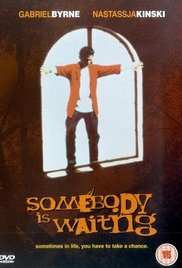

Predictions: 
['Drama']
Actual Genres: 
['Drama']


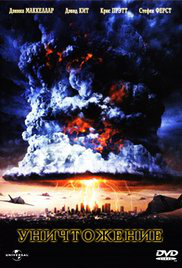

Predictions: 
['Sci-Fi', 'Action']
Actual Genres: 
['Sci-Fi', 'Action']


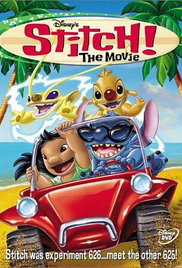

Predictions: 
['Animation', 'Comedy', 'Family']
Actual Genres: 
['Animation', 'Comedy', 'Family']


In [9]:
# Show Some Correct Results
for img in (os.listdir("/home/ubuntu/notebooks/dataset/test")):
    correct, outlabels, labels = Evaluation("/home/ubuntu/notebooks/dataset/test", 
                                            img, 
                                            classifier, 
                                            networks, 
                                            id2genre,
                                            genresTable)
    if correct == 1 and outlabels.sum(1).sum() == 1:
        image = io.imread(os.path.join("/home/ubuntu/notebooks/dataset/test", img))
        image = Image.fromarray(image)
        image = loader(image)
        lab_utils.show_image(lab_utils.tensor2pil(image))
        genre_pred = outlabels[0].nonzero()
        print "Predictions: "
        predictions = []
        for i in range(genre_pred.size()[0]):
            predictions.append(genresTablerev[genre_pred[i][0]])
        print predictions
        truth = []
        genre_true = labels[0].nonzero()
        for i in range(genre_true.size()[0]):
            truth.append(genresTablerev[genre_true[i][0]])
        print "Actual Genres: "
        print truth
        break
        
for img in (os.listdir("/home/ubuntu/notebooks/dataset/test")):
    correct, outlabels, labels = Evaluation("/home/ubuntu/notebooks/dataset/test", 
                                            img, 
                                            classifier, 
                                            networks, 
                                            id2genre,
                                            genresTable)
    if correct == 1 and outlabels.sum(1).sum() == 2:
        image = io.imread(os.path.join("/home/ubuntu/notebooks/dataset/test", img))
        image = Image.fromarray(image)
        image = loader(image)
        lab_utils.show_image(lab_utils.tensor2pil(image))
        genre_pred = outlabels[0].nonzero()
        print "Predictions: "
        predictions = []
        for i in range(genre_pred.size()[0]):
            predictions.append(genresTablerev[genre_pred[i][0]])
        print predictions
        truth = []
        genre_true = labels[0].nonzero()
        for i in range(genre_true.size()[0]):
            truth.append(genresTablerev[genre_true[i][0]])
        print "Actual Genres: "
        print truth
        break
        
for img in (os.listdir("/home/ubuntu/notebooks/dataset/test")):
    correct, outlabels, labels = Evaluation("/home/ubuntu/notebooks/dataset/test", 
                                            img, 
                                            classifier, 
                                            networks, 
                                            id2genre,
                                            genresTable)
    if correct == 1 and outlabels.sum(1).sum() == 3:
        image = io.imread(os.path.join("/home/ubuntu/notebooks/dataset/test", img))
        image = Image.fromarray(image)
        image = loader(image)
        lab_utils.show_image(lab_utils.tensor2pil(image))
        genre_pred = outlabels[0].nonzero()
        print "Predictions: "
        predictions = []
        for i in range(genre_pred.size()[0]):
            predictions.append(genresTablerev[genre_pred[i][0]])
        print predictions
        truth = []
        genre_true = labels[0].nonzero()
        for i in range(genre_true.size()[0]):
            truth.append(genresTablerev[genre_true[i][0]])
        print "Actual Genres: "
        print truth
        break     

### Show Some Wrong Results

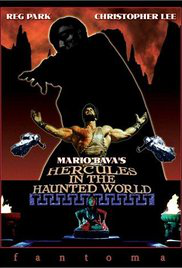

Predictions: 
['Action']
Actual Genres: 
['Horror', 'Adventure', 'Fantasy']


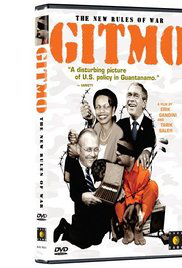

Predictions: 
['Comedy', 'Drama']
Actual Genres: 
['Documentary']


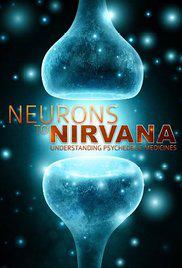

Predictions: 
['Sci-Fi', 'Horror', 'Thriller']
Actual Genres: 
['Documentary', 'History']


In [10]:
# Show Some Wrong Results
for img in (os.listdir("/home/ubuntu/notebooks/dataset/test")):
    correct, outlabels, labels = Evaluation("/home/ubuntu/notebooks/dataset/test", 
                                            img, 
                                            classifier, 
                                            networks, 
                                            id2genre,
                                            genresTable)
    if correct == 0 and outlabels.sum(1).sum() == 1:
        image = io.imread(os.path.join("/home/ubuntu/notebooks/dataset/test", img))
        image = Image.fromarray(image)
        image = loader(image)
        lab_utils.show_image(lab_utils.tensor2pil(image))
        genre_pred = outlabels[0].nonzero()
        print "Predictions: "
        predictions = []
        for i in range(genre_pred.size()[0]):
            predictions.append(genresTablerev[genre_pred[i][0]])
        print predictions
        truth = []
        genre_true = labels[0].nonzero()
        for i in range(genre_true.size()[0]):
            truth.append(genresTablerev[genre_true[i][0]])
        print "Actual Genres: "
        print truth
        break
        
for img in (os.listdir("/home/ubuntu/notebooks/dataset/test")):
    correct, outlabels, labels = Evaluation("/home/ubuntu/notebooks/dataset/test", 
                                            img, 
                                            classifier, 
                                            networks, 
                                            id2genre,
                                            genresTable)
    if correct == 0 and outlabels.sum(1).sum() == 2:
        image = io.imread(os.path.join("/home/ubuntu/notebooks/dataset/test", img))
        image = Image.fromarray(image)
        image = loader(image)
        lab_utils.show_image(lab_utils.tensor2pil(image))
        genre_pred = outlabels[0].nonzero()
        print "Predictions: "
        predictions = []
        for i in range(genre_pred.size()[0]):
            predictions.append(genresTablerev[genre_pred[i][0]])
        print predictions
        truth = []
        genre_true = labels[0].nonzero()
        for i in range(genre_true.size()[0]):
            truth.append(genresTablerev[genre_true[i][0]])
        print "Actual Genres: "
        print truth
        break
        
for img in (os.listdir("/home/ubuntu/notebooks/dataset/test")):
    correct, outlabels, labels = Evaluation("/home/ubuntu/notebooks/dataset/test", 
                                            img, 
                                            classifier, 
                                            networks, 
                                            id2genre,
                                            genresTable)
    if correct == 0 and outlabels.sum(1).sum() == 3:
        image = io.imread(os.path.join("/home/ubuntu/notebooks/dataset/test", img))
        image = Image.fromarray(image)
        image = loader(image)
        lab_utils.show_image(lab_utils.tensor2pil(image))
        genre_pred = outlabels[0].nonzero()
        print "Predictions: "
        predictions = []
        for i in range(genre_pred.size()[0]):
            predictions.append(genresTablerev[genre_pred[i][0]])
        print predictions
        truth = []
        genre_true = labels[0].nonzero()
        for i in range(genre_true.size()[0]):
            truth.append(genresTablerev[genre_true[i][0]])
        print "Actual Genres: "
        print truth
        break

### Show Some Partly Correct Results

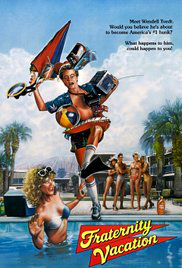

Predictions: 
['Comedy', 'Action']
Actual Genres: 
['Comedy']


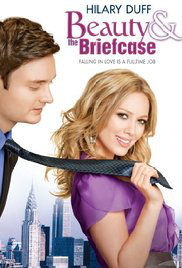

Predictions: 
['Romance', 'Comedy', 'Drama']
Actual Genres: 
['Romance', 'Comedy']


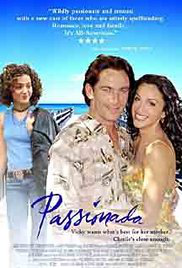

Predictions: 
['Drama']
Actual Genres: 
['Romance', 'Comedy', 'Drama']


In [11]:
# Show Some Partly Correct Results
        
for img in (os.listdir("/home/ubuntu/notebooks/dataset/test")):
    correct, outlabels, labels = Evaluation("/home/ubuntu/notebooks/dataset/test", 
                                            img, 
                                            classifier, 
                                            networks, 
                                            id2genre,
                                            genresTable)
    if correct != 0 and correct != 1 and outlabels.sum(1).sum() == 2:
        image = io.imread(os.path.join("/home/ubuntu/notebooks/dataset/test", img))
        image = Image.fromarray(image)
        image = loader(image)
        lab_utils.show_image(lab_utils.tensor2pil(image))
        genre_pred = outlabels[0].nonzero()
        print "Predictions: "
        predictions = []
        for i in range(genre_pred.size()[0]):
            predictions.append(genresTablerev[genre_pred[i][0]])
        print predictions
        truth = []
        genre_true = labels[0].nonzero()
        for i in range(genre_true.size()[0]):
            truth.append(genresTablerev[genre_true[i][0]])
        print "Actual Genres: "
        print truth
        break
        
for img in (os.listdir("/home/ubuntu/notebooks/dataset/test")):
    correct, outlabels, labels = Evaluation("/home/ubuntu/notebooks/dataset/test", 
                                            img, 
                                            classifier, 
                                            networks, 
                                            id2genre,
                                            genresTable)
    if correct != 0 and correct != 1 and outlabels.sum(1).sum() == 3:
        image = io.imread(os.path.join("/home/ubuntu/notebooks/dataset/test", img))
        image = Image.fromarray(image)
        image = loader(image)
        lab_utils.show_image(lab_utils.tensor2pil(image))
        genre_pred = outlabels[0].nonzero()
        print "Predictions: "
        predictions = []
        for i in range(genre_pred.size()[0]):
            predictions.append(genresTablerev[genre_pred[i][0]])
        print predictions
        truth = []
        genre_true = labels[0].nonzero()
        for i in range(genre_true.size()[0]):
            truth.append(genresTablerev[genre_true[i][0]])
        print "Actual Genres: "
        print truth
        break
        
for img in (os.listdir("/home/ubuntu/notebooks/dataset/test")):
    correct, outlabels, labels = Evaluation("/home/ubuntu/notebooks/dataset/test", 
                                            img, 
                                            classifier, 
                                            networks, 
                                            id2genre,
                                            genresTable)
    if correct != 0 and correct != 1 and labels.sum(1).sum() == 3:
        image = io.imread(os.path.join("/home/ubuntu/notebooks/dataset/test", img))
        image = Image.fromarray(image)
        image = loader(image)
        lab_utils.show_image(lab_utils.tensor2pil(image))
        genre_pred = outlabels[0].nonzero()
        print "Predictions: "
        predictions = []
        for i in range(genre_pred.size()[0]):
            predictions.append(genresTablerev[genre_pred[i][0]])
        print predictions
        truth = []
        genre_true = labels[0].nonzero()
        for i in range(genre_true.size()[0]):
            truth.append(genresTablerev[genre_true[i][0]])
        print "Actual Genres: "
        print truth
        break